In [50]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
from sklearn.metrics import mean_squared_error # Mean-squared error function

# Coursework 1 :
See pdf for instructions. 

In [51]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "01482462" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "yw24218" # Return your short imperizal login

## Helper class

In [52]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()
    plt.savefig('grid.jpg')

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()
    plt.savefig('value.jpg')


## Maze class

In [53]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    # [Action required]
    # Properties set from the CID
    self._prob_success = 0.8 + 0.02 * (9 - 6) # float
    self._gamma = 0.8 + 0.02 * 6 # float
    self._goal = 2 % 4 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

## DP Agent

In [54]:
# This class define the Dynamic Programing agent 

class DP_agent(object):


  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # for policy iteration
    # policy, V = self.policy_iteration(env)
    # for value iteration
    policy, V = self.value_iteration(env)
  
    return policy, V

  def policy_evaluation(self, env, policy, threshold=0.0001):
    """
    Evaluate the value function of a given policy
    input: 
      - env {Maze object} -- Maze to solve
      - policy {np.array} -- policy to evaluate
      - threshold {float} -- threshold for convergence
    output: 
      - V {np.array} -- Value function of the given policy
    """
    delta = 2 * threshold
    V = np.zeros(env.get_state_size())
    Vnew = np.zeros(env.get_state_size())
    while delta > threshold:
      for prior_state in range(env.get_state_size()):
        if not env.get_absorbing()[0, prior_state]:
          tempV = 0
          for action in range(env.get_action_size()):
            tempQ = 0
            for post_state in range(env.get_state_size()):
              tempQ += env.get_T()[prior_state, post_state, action] * (env.get_R()[prior_state, post_state, action] + env.get_gamma() * V[post_state])
            tempV += policy[prior_state, action] * tempQ
          Vnew[prior_state] = tempV
      delta = max(abs(Vnew - V))
          
      V = np.copy(Vnew)
    return V

  def policy_iteration(self, env):
    """
    Solve a given Maze environment using Policy Iteration
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # Initialisation (can be edited)
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    policy[:, 0] = 1
    policy_stable = False

    while not policy_stable:
      V = self.policy_evaluation(env, policy)
      policy_stable = True
      for prior_state in range(env.get_state_size()):
        if not env.get_absorbing()[0, prior_state]:
          old_action = np.argmax(policy[prior_state, :])
          
          Q = np.zeros(env.get_action_size())
          for post_state in range(env.get_state_size()):
            Q += env.get_T()[prior_state, post_state, :] * (env.get_R()[prior_state, post_state, :] + env.get_gamma() * V[post_state])

          new_policy = np.zeros(env.get_action_size())
          new_policy[np.argmax(Q)] = 1
          policy[prior_state, :] = new_policy
          if old_action != np.argmax(policy[prior_state, :]):
            policy_stable = False
  
    return policy, V

  def value_iteration(self, env, threshold=0.0001):
    """
    Solve a given Maze environment using Value Iteration
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # Initialisation (can be edited)
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    V = np.zeros(env.get_state_size())

    delta = 2 * threshold
    while delta > threshold:
      delta = 0
      for prior_state in range(env.get_state_size()):
        if not env.get_absorbing()[0, prior_state]:
          v = V[prior_state]
          Q = np.zeros(env.get_action_size())
          for post_state in range(env.get_state_size()):
            Q += env.get_T()[prior_state, post_state, :] * (env.get_R()[prior_state, post_state, :] + env.get_gamma() * V[post_state])
          V[prior_state] = np.max(Q)
          delta = max(delta, abs(v - V[prior_state]))

    for prior_state in range(env.get_state_size()):
      Q = np.zeros(env.get_action_size())
      for post_state in range(env.get_state_size()):
        Q += env.get_T()[prior_state, post_state, :] * (env.get_R()[prior_state, post_state, :] + env.get_gamma() * V[post_state])
      policy[prior_state, np.argmax(Q)] = 1
    return policy, V

## MC agent

In [55]:
# This class define the Monte-Carlo agent

class MC_agent(object):
  def __init__(self,  epsilon = 0.2, alpha = 0.01):
    self._epsilon = epsilon
    self._alpha = alpha
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    N = np.zeros((env.get_state_size(), env.get_action_size()))
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size()))
    values = [V]
    total_rewards = []
    epsilon = self._epsilon
    # N = np.zeros((env.get_state_size(), env.get_action_size()))
    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####
    while True:
      episode = []
      done = False
      t, state, reward, done = env.reset()
      while not done:
        action = 0
        #epsilon-greedy
        if np.random.rand() < epsilon:
          action = np.random.randint(env.get_action_size())
        else:
          action = np.argmax(Q[state, :])
        t, next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
      total_rewards.append(sum([x[2] for x in episode]))
      G = 0
      for state, action, reward in reversed(episode):
        # N[state, action] += 1
        # learning_rate = 1 / N[state, action] if self._alpha == 1.1 else self._alpha
        G = reward + env.get_gamma() * G
        Q[state, action] += self._alpha * (G - Q[state, action])
      newV = np.max(Q, axis=1)
      policy = np.zeros((env.get_state_size(), env.get_action_size()))
      policy[np.arange(env.get_state_size()), np.argmax(Q, axis=1)] = 1
      values.append(newV)
      V = newV
      if len(total_rewards) > 5000:
        break
      



    return policy, values, total_rewards

## TD agent

In [56]:
# This class define the Temporal-Difference agent

class TD_agent(object):
  def __init__(self,  epsilon = 0.2, alpha = 0.01):
    self._epsilon = epsilon
    self._alpha = alpha
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    values = [V]
    total_rewards = []
    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####
    
    while True:
      episode_reward = []

      done = False
      t, state, reward, done = env.reset()
      while not done:
        action = 0
        if np.random.rand() < self._epsilon:
          action = np.random.randint(env.get_action_size())
        else:
          action = np.argmax(Q[state, :])
        t, next_state, reward, done = env.step(action)
        Q[state, action] += self._alpha * (reward + env.get_gamma() * np.max(Q[next_state, :]) - Q[state, action])
        state = next_state
        episode_reward.append(reward)
      newV = np.max(Q, axis=1)
      policy = np.zeros((env.get_state_size(), env.get_action_size()))
      policy[np.arange(env.get_state_size()), np.argmax(Q, axis=1)] = 1
      values.append(newV)
      V = newV
      total_rewards.append(sum(episode_reward))
      if len(total_rewards) > 5000:
        break
    
    return policy, values, total_rewards

## Example main

Creating the Maze:



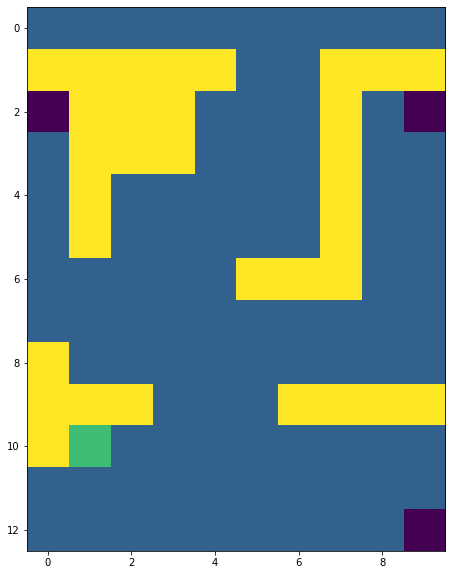

Results of the DP agent:



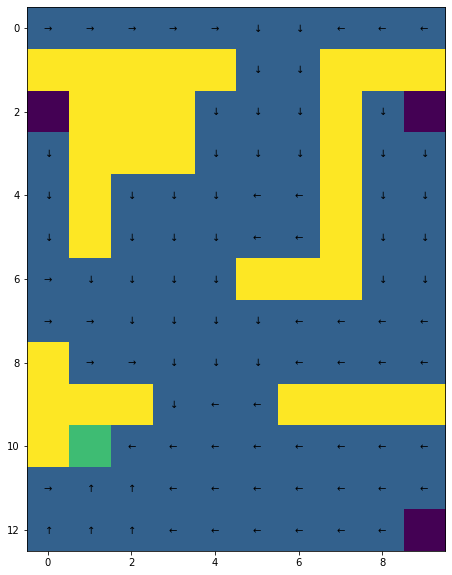

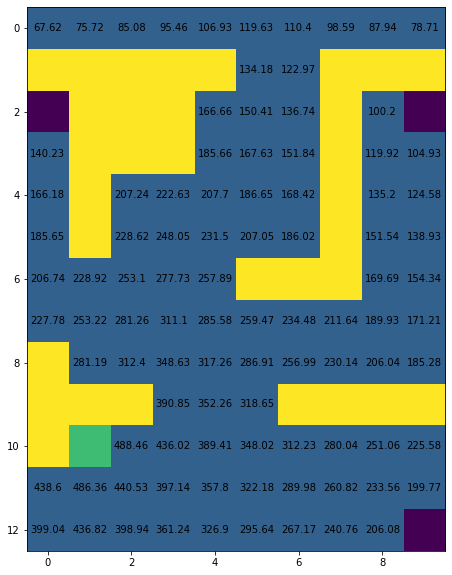

Results of the MC agent:



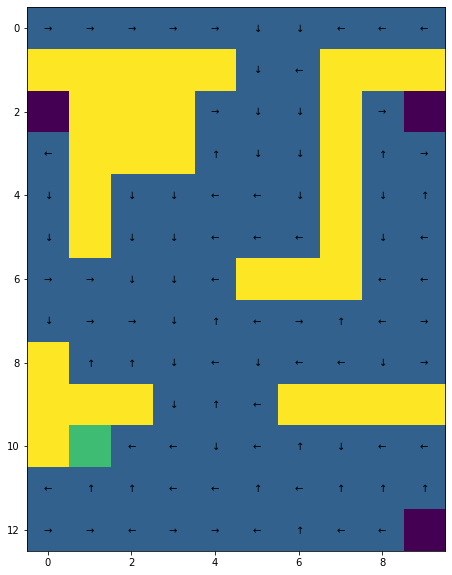

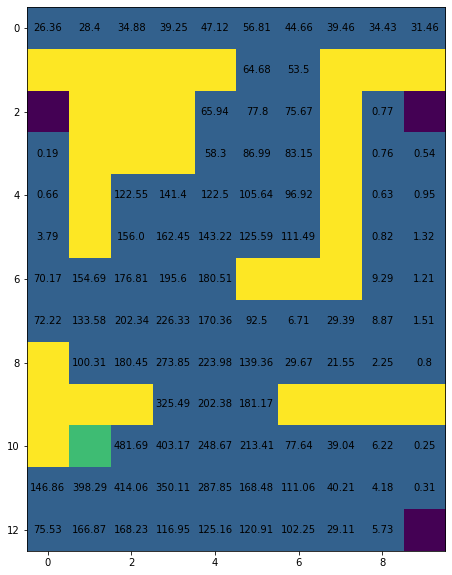

Results of the TD agent:



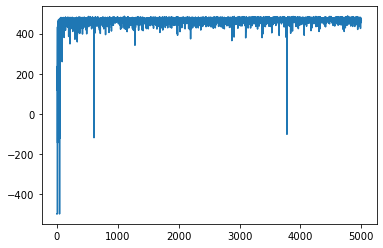

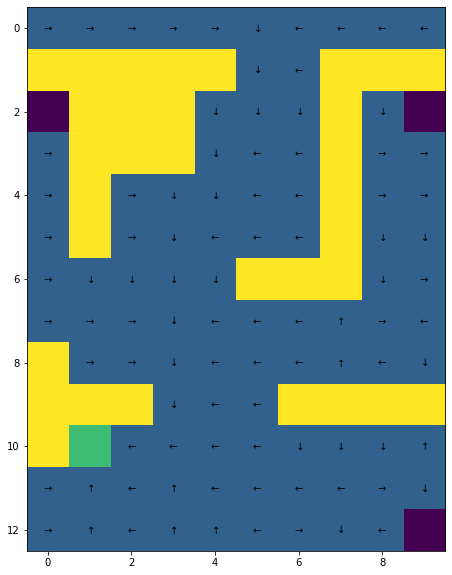

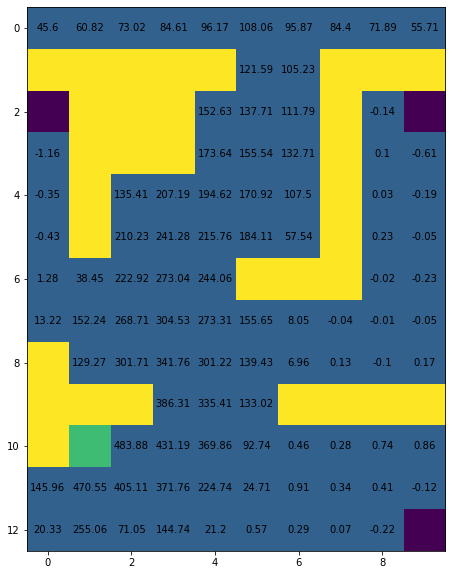

Mean square error between the value function of the TD agent and the value function of the DP agent:  23837.075149227792


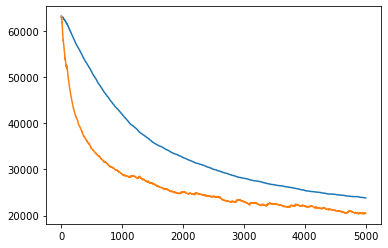

In [57]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


### Question 2: Monte-Carlo learning

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards2 = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])

# plot the learning curve against the number of episodes
plt.plot(total_rewards2)

### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards3 = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

# mean quare error between the value function of the TD agent and the value function of the DP agent
print("Mean square error between the value function of the TD agent and the value function of the DP agent: ", np.mean((np.array(td_values[-1]) - np.array(dp_value))**2))
# plot the error against the number of episodes
plt.plot(np.mean((np.array(td_values) - np.array(dp_value))**2, axis=1))
# plot the error between the MC and DP agent
plt.plot(np.mean((np.array(mc_values) - np.array(dp_value))**2, axis=1))
#save the figure
plt.savefig('error.png')

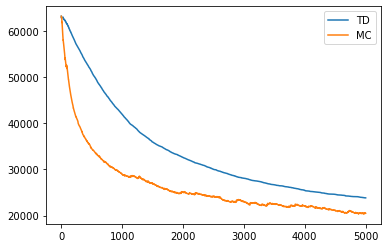

In [58]:
plt.plot(np.mean((np.array(td_values) - np.array(dp_value))**2, axis=1), label='TD')
#add the line color label
# plot the error between the MC and DP agent
plt.plot(np.mean((np.array(mc_values) - np.array(dp_value))**2, axis=1), label='MC')
plt.legend()
#save the figure
plt.savefig('error.jpg')

In [59]:
# mc_agent = MC_agent()
# replication = []
# for i in range(300):
#     mc_agent = MC_agent()
#     mc_policy, mc_values, total_rewards2 = mc_agent.solve(maze)
#     replication.append(total_rewards2)


In [60]:
# replication = np.array(replication)
# #print(replication)
# res = [np.std(replication[:i+1], axis=1).mean() for i in range(replication.shape[0])]
# plt.plot(res)
    

In [61]:
# replication[:2]

In [62]:
replications = []
for i in range(100):
    mc_agent = MC_agent()
    mc_policy, mc_values, total_rewards20 = mc_agent.solve(maze)
    replications.append(total_rewards20)

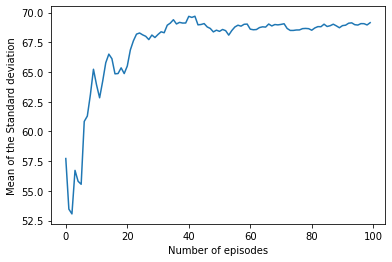

In [63]:
replications = np.array(replications)
#print(replication)
mean = np.array([np.mean(replications[:i+1], axis=1).mean() for i in range(replications.shape[0])])

res = np.array([np.std(replications[:i+1], axis=1).mean() for i in range(replications.shape[0])])
#plot the graph with coordinate x and y
# plt.plot(mean)
plt.plot(res)
# plt.plot(mean - res)
plt.xlabel('Number of episodes')
plt.ylabel('Mean of the Standard deviation')
plt.savefig('Q2_3.jpg', dpi=300, bbox_inches='tight')


In [64]:
#calculate the standard deviation of each column of the array
sd = np.std(replications, axis=0)
# plt.plot(np.std(replications, axis=0))

(5001,)


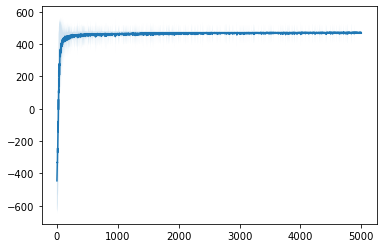

In [65]:
t_mean = np.mean(replications, axis=0)
t_sd = np.std(replications, axis=0)
print(t_sd.shape)
#for each column, t_mean - t_sd
# plt.plot(t_mean - t_sd)
plt.fill_between(range(len(t_mean)), t_mean - t_sd, t_mean + t_sd, alpha=0.2)
plt.plot(t_mean)
plt.savefig('Q2_4.jpg', dpi=300, bbox_inches='tight')

In [71]:

# plt.fill_between(range(len(mean)), mean - sd, mean + sd, alpha=0.1)

# #the y axis is from 0 to 100
# # plt.ylim(0, 100)
# plt.savefig('Q2_3_20.jpg', dpi=300, bbox_inches='tight')

In [ ]:
#2.5 varying epsilon and alpha in MC agent
a = []
for i in range(10):
    mc_agent = MC_agent(epsilon = 0.1 * i)
    mc_policy, mc_values, total_rewards20 = mc_agent.solve(maze)
    a.append(total_rewards20)
    


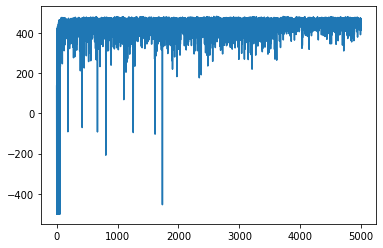

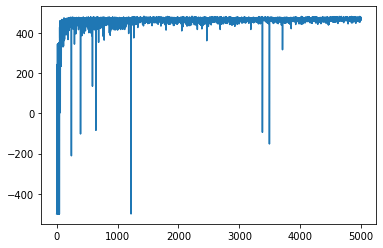

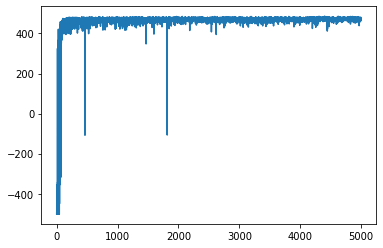

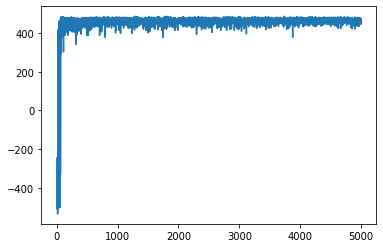

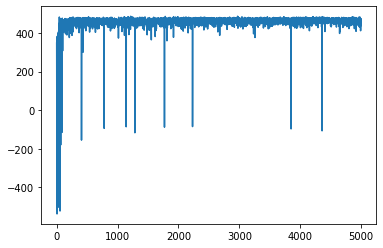

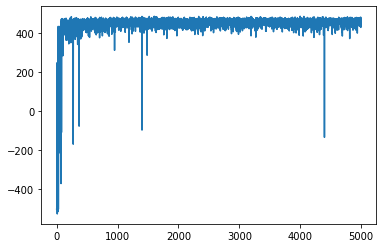

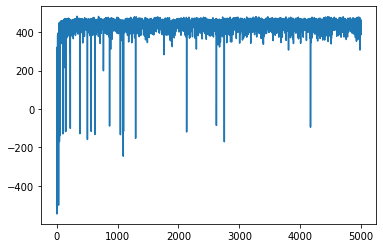

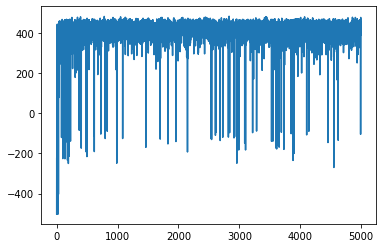

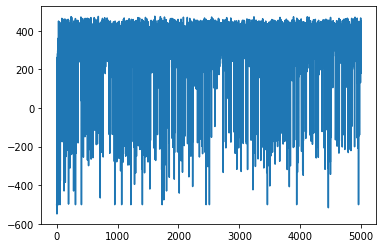

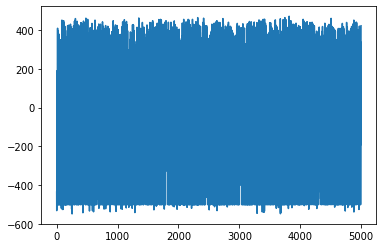

In [ ]:
# plot all the elements in a in different graphs

for i in range(len(a)):
    plt.figure(i)
    
    plt.plot(a[i])
    plt.savefig('{}.jpg'.format(i), dpi=300, bbox_inches='tight')

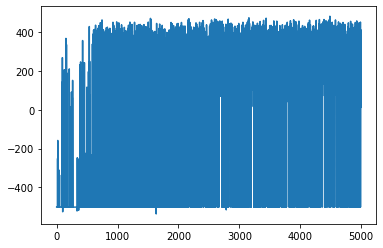

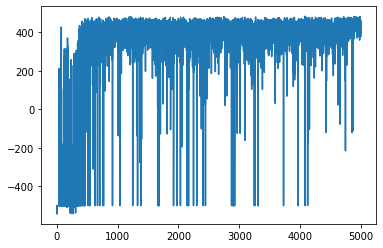

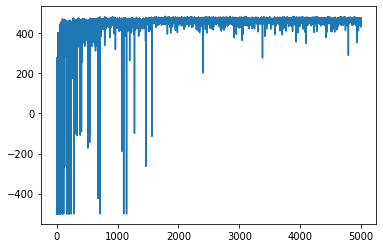

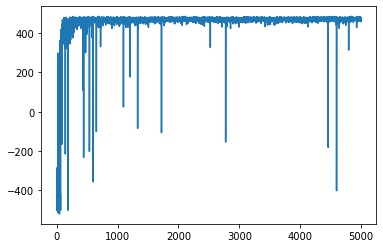

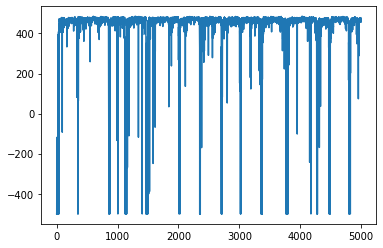

In [ ]:
#2.5 varying alpha in MC agent
b = []
for i in range(5):
    mc_agent = MC_agent(alpha = 0.00001 * 10**i)
    mc_policy, mc_values, total_rewards20 = mc_agent.solve(maze)
    b.append(total_rewards20)

# plot all the elements in a in different graphs

for i in range(len(b)):
    plt.figure(i)
    
    plt.plot(b[i])
    plt.savefig('{}_alpha.jpg'.format(i), dpi=300, bbox_inches='tight')

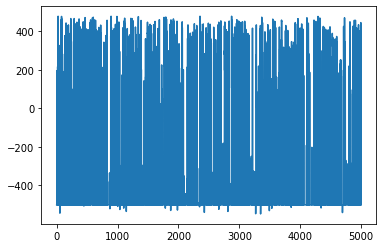

In [ ]:
mc_agent = MC_agent(alpha=1)
mc_policy, mc_values, total_rewards20 = mc_agent.solve(maze)
plt.plot(total_rewards20)

In [ ]:
td_agent = TD_agent()
c = []
#plotting the learning curve of the TD agent
for i in range(20):
    td_policy, td_values, total_rewards20 = td_agent.solve(maze)
    c.append(total_rewards20)

# calculate the mean of the learning curve
mean = np.mean(c, axis=0)
# calculate the standard deviation of the learning curve
sd = np.std(c, axis=0)


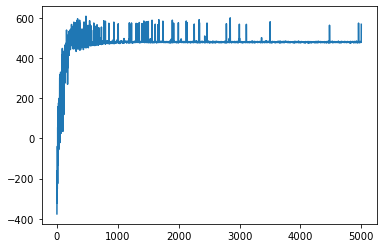

In [ ]:
plt.plot(mean + sd)

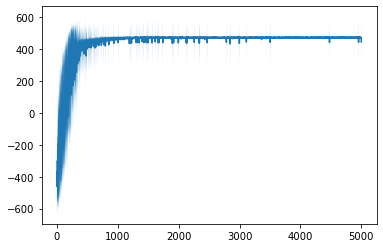

In [ ]:

plt.fill_between(range(len(mean)), mean - sd, mean + sd, alpha=1)
plt.plot(mean)
plt.savefig('Q2_3_3.jpg', dpi=300, bbox_inches='tight')

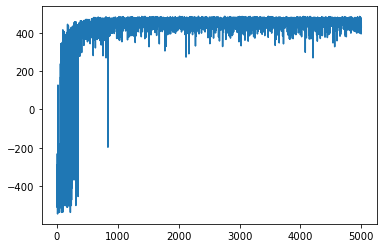

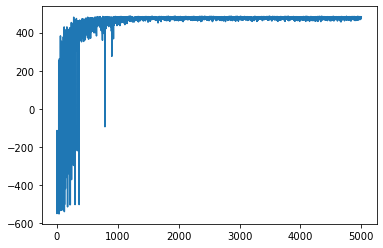

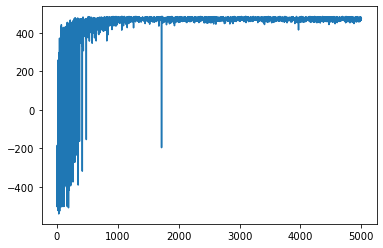

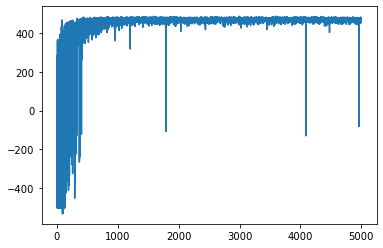

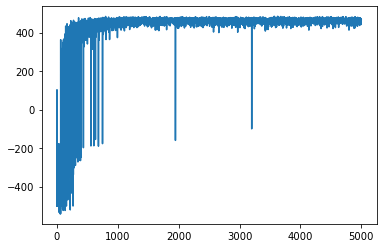

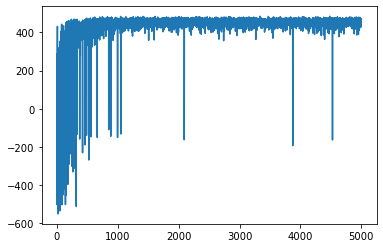

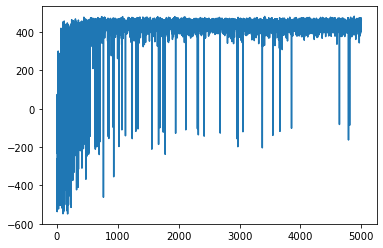

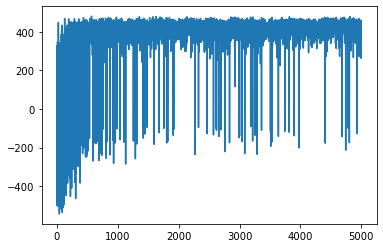

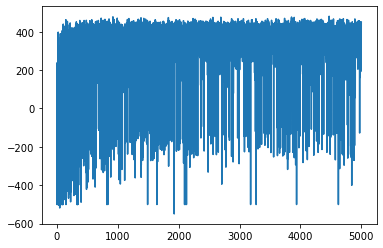

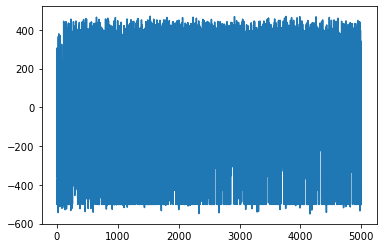

In [ ]:
# varying epsilon in TD agent
for i in range(10):
    td_agent = TD_agent(epsilon = 0.1 * i)
    td_policy, td_values, total_rewards20 = td_agent.solve(maze)
    plt.figure(i)
    plt.plot(total_rewards20)
    plt.savefig('{}_TD_epsilon.jpg'.format(i), dpi=300, bbox_inches='tight')

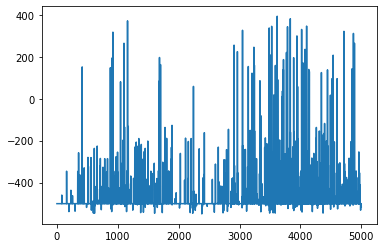

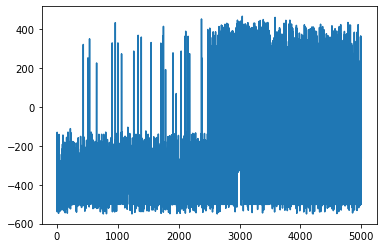

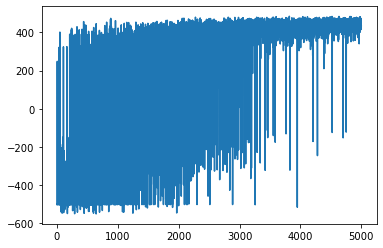

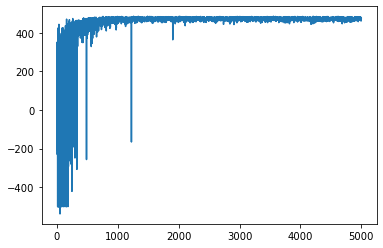

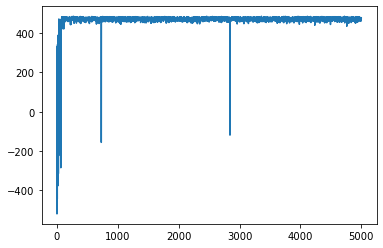

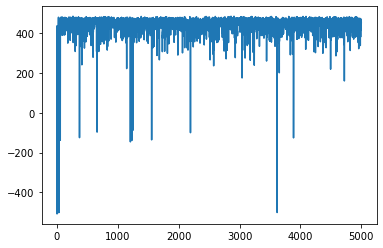

In [ ]:
# varying alpha in TD agent
for i in range(6):
    td_agent = TD_agent(alpha = 0.00001 * 10**i)
    td_policy, td_values, total_rewards20 = td_agent.solve(maze)
    plt.figure(i)
    plt.plot(total_rewards20)
    plt.savefig('{}_TD_alpha.jpg'.format(i), dpi=300, bbox_inches='tight')

In [ ]:
replications_base = []
replications_td = []
replications_mc = []
for i in range(20):
    mc_agent = MC_agent()
    mc_policy, mc_values, total_rewards = mc_agent.solve(maze)
    replications_mc.append((mc_values, total_rewards))
    
    td_agent = TD_agent()
    td_policy, td_values, total_rewards = td_agent.solve(maze)
    replications_td.append((td_values, total_rewards))
    
    base_agent = DP_agent()
    base_policy, base_values = base_agent.solve(maze)
    replications_base.append(base_values)

In [ ]:
# estimation error for TD and MC against the number of episodes
import sklearn.metrics as metrics

replications_base = np.array(replications_base)
mc_values = np.array([i[0][-1] for i in replications_mc])
mc_total_rewards = np.array([i[1] for i in replications_mc])



In [ ]:
mc_values.shape

(20, 98)

In [ ]:
# mean square error of MC 
mse1 = np.array([np.mean(metrics.mean_squared_error(mc_values[i],replications_base[0])) for i in range(mc_values.shape[0])])
mse1 = np.array([np.mean(mse1[:i+1]) for i in range(mse1.shape[0])])

In [ ]:
plt.figure(1, figsize=(10, 5))
# plt.savefig('Q4_1_MC.jpg', dpi=300, bbox_inches='tight')

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [ ]:
td_values = np.array([i[0][-2] for i in replications_td])
td_total_rewards = np.array([i[1] for i in replications_td])
# plt.plot(np.mean((np.array(td_values) - np.array(dp_value))**2, axis=1), label='TD')

# mean square error of TD
mse = np.array([metrics.mean_squared_error( td_values[i],replications_base[0]) for i in range(td_values.shape[0])])
mse

array([8494.77716975, 9163.1538521 , 8733.35550889, 9086.62790444,
       8732.7375937 , 8897.06750191, 9827.56531562, 8790.52521998,
       9072.38348391, 8834.32531196, 9104.03310916, 8880.10103117,
       8595.96877795, 9192.7934111 , 9280.18814546, 8567.52071446,
       9484.6506089 , 9207.02058832, 8954.48521015, 8814.32238302])

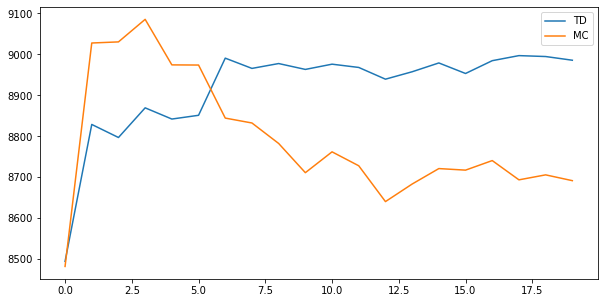

In [ ]:

mse = np.array([np.mean(mse[:i+1]) for i in range(mse.shape[0])])
# plot x-axis is the number of episodes, 20 episodes
plt.figure(1, figsize=(10, 5))
plt.plot(mse)
plt.plot(mse1)
plt.legend(['TD', 'MC'])
plt.savefig('Q4_1.jpg', dpi=300, bbox_inches='tight')


In [ ]:
print(td_total_rewards.shape, mc_total_rewards.shape, mse.shape, mse1.shape)

(20, 5001) (20, 5001) (20,) (20,)


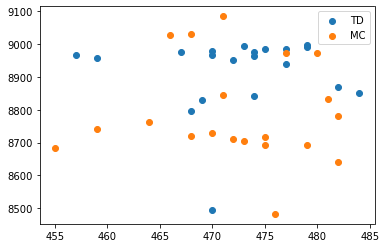

In [ ]:
# a scatter plot the estimation error for an episode against the total non-discounted sum of reward for that episode for both TD and MC learners.
# plt.figure(1, figsize=(10, 10))
plt.scatter(td_total_rewards[:,-1], mse, label='TD')
plt.scatter(mc_total_rewards[:,-1], mse1, label='MC')
# the instance
plt.legend()
plt.savefig('Q4_3_TD.jpg', dpi=300, bbox_inches='tight')


In [ ]:
np.array(replications_td).shape

C:\Users\yanbo\AppData\Local\Temp/ipykernel_12788/4038262843.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(replications_td).shape


(20, 2)